### 3.8 연습 문제
#### 1. MNIST 데이터셋으로 분류기 KNeighborsClassifier를 이용해서 학습을 하고 정확도가 testset에서 97%가 나올 수 있도록 하자.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)

In [2]:
trainsplit = 6000
x,y = mnist['data'], mnist['target']
y = y.astype(np.int64)
x_train, y_train,x_test, y_test = x[:trainsplit], y[:trainsplit], x[trainsplit:], y[trainsplit:]
#이 문제가 다중 레이블 분류는 아니지만 일단 문제의 요구 사항은 KNeighborClassifier을 이용하는 것이다.
from sklearn.neighbors import KNeighborsClassifier
nbor_clf = KNeighborsClassifier()
nbor_clf.fit(x_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [3]:
y[0]

5

In [4]:
from sklearn.model_selection import cross_val_score

In [5]:
cross_val_score(nbor_clf, x_train, y_train, cv = 3, scoring = 'accuracy')

array([0.921, 0.934, 0.926])

- 목표한 정확도 97%가 아니기 때문에 GridSearchCV를 이용해서 그리드 탐색을 진행해보고자 한다.
- 여기서 조정해야할 하이퍼파라미터는 weight, n_neighbors이다.

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'n_neighbors':[3,4,5], 'weights':['uniform','distance']}
]

grid_search = GridSearchCV(nbor_clf, param_grid, cv = 3, scoring = 'accuracy', return_train_score = True,verbose = 3)
#verbose는 별게 아니라 그냥 진행 과정을 출력할지 말지를 결정지어준다. 그런데 학습 시간이 오래걸리니 출력 하게 함으로서 진행 상황을 알게 되는 것이 나은 것 같다.

In [7]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=3, weights=uniform, score=(train=0.974, test=0.926), total=  16.0s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.1s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.966, test=0.931), total=  15.9s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=(train=0.967, test=0.925), total=  16.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.932), total=  15.9s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.935), total=  16.3s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=(train=1.000, test=0.927), total=  16.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV]  n_neighbors=4, weights=uniform, score=(train=0.967, test=0.923), total=  16.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV]  n_neighbors=4, weights=uniform, score=(train=0.959, test=0.932), total=  16.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV]  n_neighbors=4, weights=uniform, score=(train=0.961, tes

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 14.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=3)

In [8]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [10]:
nbor_clf = KNeighborsClassifier(**grid_search.best_params_)

In [12]:
grid_search.best_score_

0.9326666666666666

In [13]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(x_test)
accuracy_score(y_test, y_pred)

0.93875

### 2. MNIST 이미지를 사방 어느 한 방향으로던지 한 픽셀 이동시킬 수 있는 함수를 만들어보고 앞서 1번에서 찾은 최선의 모델에서 훈련시켜 정확도의 차이를 본다.
  - 이미지 전처리/증식을 하라는 의미임
  - scipy.ndimage.interpolation에 shift라는 함수가 존재하고, 이를 사용할 수 있어야 한다.

In [18]:
from scipy.ndimage.interpolation import shift
def shift_image(image,dx,dy):
  image = image.reshape((28,28))
  return (shift(image, [dx,dy], cval = 0, mode = 'constant')).reshape([-1])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

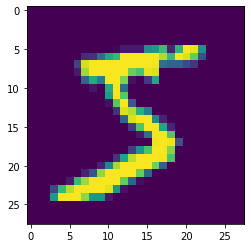

In [22]:
shifted = shift_image(x_train[0], 0,-1)
plt.imshow(x_train[0].reshape((28,28)))
plt.imshow(shifted.reshape((28,28)))

new_x_train, new_y_train = [image for image in x_train],[label for label in y_train]
dx,dy = [-2,2,0,0],[0,0,-2,2]
for _ in range(4):
  x,y = dx[_], dy[_]
  for i in range(len(x_train)):
    new_x_train.append(shift_image(x_train[i],x,y))
    new_y_train.append(y_train[i])
new_x_train = np.array(new_x_train)
new_y_train = np.array(new_y_train)
shuffle_idx = np.random.permutation(len(new_x_train))
new_x_train = new_x_train[shuffle_idx]
new_y_train = new_y_train[shuffle_idx]


nbor_clf.fit(new_x_train, new_y_train)


In [ ]:
y_pred = nbor_clf.predict(x_test)
accuracy_score(y_test, y_pred)

#### 3. Kaggle에 있는 Titanic Data를 이용해서 학습을 해보자
- 승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표이다.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
gender_data = pd.read_csv('/content/gender_submission.csv')
test_data = pd.read_csv('/content/test.csv')
train_data = pd.read_csv('/content/train.csv')

In [6]:
len(test_data), len(train_data)

(418, 891)

In [61]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 'Age', 'Cabin', 'Embarked'데이터를 제외하고는 누락된 부분은 없다고 봐도 된다.
- 'Cabin',' 'Ticket', 'Name'데이터는 사용하지 않기로 하자.
  - 'Age'데이터는 나중에 나이의 평균 값으로 누락된 데이터를 채워주어도 괜찮을 것이다.(생존 여부에 따라서)
- Train, Test data를 하나 하나 전처리 하기에는 무리가 있기 때문에 pipeline을 만들어 주는 것이 필요할 것이다.

In [10]:
train_data.describe()
#df.describe()를 적용하면 수치형 데이터에 대한 정보만 보여준다.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [18]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [19]:
train_data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [25]:
train_data['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [22]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [45]:
train_data = train_data.drop(['Cabin','Ticket','Name'],axis = 1)

In [47]:
train_data = train_data.drop('PassengerId',axis = 1)

In [48]:
test_data = test_data.drop(['Cabin','Ticket','Name','PassengerId'], axis = 1)

In [92]:
train_data['Age'].value_counts().index

Float64Index([24.0, 22.0, 18.0, 19.0, 30.0, 28.0, 21.0, 25.0, 36.0, 29.0, 32.0,
              27.0, 35.0, 26.0, 16.0, 31.0, 20.0, 33.0, 23.0, 34.0, 39.0, 17.0,
              42.0, 40.0, 45.0, 38.0, 50.0,  2.0,  4.0, 47.0, 44.0, 48.0, 54.0,
               9.0,  1.0, 51.0, 52.0, 14.0,  3.0, 49.0, 41.0, 37.0, 15.0, 43.0,
              58.0, 11.0, 62.0, 60.0,  8.0, 56.0,  5.0, 46.0, 65.0,  7.0,  6.0,
              61.0, 55.0, 28.5, 71.0, 59.0, 63.0, 0.83, 30.5, 70.0, 57.0, 0.75,
              13.0, 10.0, 64.0, 40.5, 32.5, 45.5, 20.5, 24.5, 0.67, 14.5, 0.92,
              74.0, 34.5, 80.0, 12.0, 36.5, 53.0, 55.5, 70.5, 66.0, 23.5,
              0.42],
             dtype='float64')

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder  #범주형 자료를 숫자로 바꾸어줌
from sklearn.base import BaseEstimator, TransformerMixin
#범주형 데이터에 사용할 기능
class MostFrequentImputer(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    #data frame의 경우 특정 column에 대해서 value_counts를 하면 데이터 별로 개수가 나오기 때문에 거기서.index()를하면 개수를 직접 세지 않아도 알 수 있다.
    self.most_frequent = pd.Series([x[c].value_counts().index[0] for c in x], index = x.columns)
    return self
  def transform(self, x,y=None):
    return x.fillna(self.most_frequent)


simple_impute = SimpleImputer(strategy = 'median')
one_hot = OneHotEncoder(sparse = False)
#수치형 데이터에 사용할 기능
simple_impute = SimpleImputer(strategy = 'median')
one_hot = OneHotEncoder(sparse = False)




In [50]:
# 숫자형 자료를 다루기 위해서는 비어있는 수치를 중간값으로 변경시키는 것을 시도
num_pipeline = Pipeline([
  ('simple_impute', SimpleImputer(strategy = 'median'))
])

In [51]:
# 범주형 자료를 다루기 위해서는 따로 class를 만들었는데, 가장 자주 쓰였던 데이터로 빈자리를 채워주고 원핫인코딩으로 문자형 데이터를 수치형 데이터로 바꾸어 주었다.
cat_pipeline = Pipeline([
  ('most_frequent', MostFrequentImputer()),
  ('one_hot', OneHotEncoder(sparse = False))
])

In [57]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Survived','Pclass', 'Age','SibSp','Parch','Fare',]
cat_attribs = ['Sex','Embarked']
train_full_pipeline = ColumnTransformer([
  ('num', num_pipeline, num_attribs),
  ('cat', cat_pipeline, cat_attribs)
])

In [62]:
new_train_data = full_pipeline.fit_transform(train_data)

In [63]:
new_train_data

array([[ 0.,  3., 22., ...,  0.,  0.,  1.],
       [ 1.,  1., 38., ...,  1.,  0.,  0.],
       [ 1.,  3., 26., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  3., 28., ...,  0.,  0.,  1.],
       [ 1.,  1., 26., ...,  1.,  0.,  0.],
       [ 0.,  3., 32., ...,  0.,  1.,  0.]])

In [70]:
x_train, y_train = new_train_data[:,1:], new_train_data[:,0]

In [71]:
x_train

array([[ 3., 22.,  1., ...,  0.,  0.,  1.],
       [ 1., 38.,  1., ...,  1.,  0.,  0.],
       [ 3., 26.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 3., 28.,  1., ...,  0.,  0.,  1.],
       [ 1., 26.,  0., ...,  1.,  0.,  0.],
       [ 3., 32.,  0., ...,  0.,  1.,  0.]])

In [72]:
y_train

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0.

In [73]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [74]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, x_train, y_train, scoring = 'accuracy')

array([0.58659218, 0.71348315, 0.69101124, 0.68539326, 0.69101124])

In [78]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_clf.fit(x_train, y_train)
scores = cross_val_score(forest_clf, x_train, y_train, scoring = 'accuracy')
scores.mean()

0.811461929571276

In [79]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train, y_train)
cross_val_score(tree_clf, x_train, y_train, scoring = 'accuracy').mean()

0.7800577490427469

In [80]:
from sklearn.neighbors import KNeighborsClassifier
nbor_clf = KNeighborsClassifier()
nbor_clf.fit(x_train, y_train)
cross_val_score(nbor_clf, x_train,y_train,scoring = 'accuracy').mean()

0.7048521750047079

In [85]:
from sklearn.model_selection import GridSearchCV
#지금까지 시도해본 분류기들 중에서 제일 효과가 좋은 분류기는 RandomForestClassifier이었기 때문에 이를 이용해서 최적의 파라미터를 구해보고자 한다.
param_grid = [
  {'class_weight':['balanced', 'balanced_subsample']},
  {'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
]

grid_search = GridSearchCV(forest_clf, param_grid, cv = 5,scoring = 'accuracy',return_train_score = True, verbose = 1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random

In [86]:
forest_clf = grid_search.best_estimator_
grid_search.best_score_

0.8148389931579938